In [1]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
replace __MACOSX/._dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd

In [0]:
INIT_LR = 1e-3 # learning rate
EPOCHS = 25 
BS = 8 #batch Size

In [0]:
dataset = '/content/dataset'
imagePaths = list(paths.list_images(dataset))
data = []
labels = []

In [0]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	data.append(image)
	labels.append(label)

In [0]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [0]:
#one hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [0]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [0]:
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [0]:
#transfer learning using pre trainded VGG16 model
Pre_Trained_Model = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [0]:
model = Pre_Trained_Model.output
model = AveragePooling2D(pool_size=(4, 4))(model)
model = Flatten(name="flatten")(model)
model = Dense(64, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)

In [0]:
model = Model(inputs=Pre_Trained_Model.input, outputs=model)

In [0]:
for layer in Pre_Trained_Model.layers:
	layer.trainable = False

In [0]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
model.compile(loss='categorical_crossentropy',optimizer= opt, metrics=['accuracy'])

In [15]:
history = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
5/5 [==============================] - 2s 302ms/step - loss: 0.8296 - accuracy: 0.5750 - val_loss: 0.6733 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 1s 109ms/step - loss: 0.7171 - accuracy: 0.5500 - val_loss: 0.6553 - val_accuracy: 0.6000
Epoch 3/25
5/5 [==============================] - 1s 106ms/step - loss: 0.7412 - accuracy: 0.5500 - val_loss: 0.6324 - val_accuracy: 0.8000
Epoch 4/25
5/5 [==============================] - 1s 109ms/step - loss: 0.7564 - accuracy: 0.5500 - val_loss: 0.6088 - val_accuracy: 1.0000
Epoch 5/25
5/5 [==============================] - 1s 108ms/step - loss: 0.7418 - accuracy: 0.5500 - val_loss: 0.5981 - val_accuracy: 0.6000
Epoch 6/25
5/5 [==============================] - 1s 111ms/step - loss: 0.7820 - accuracy: 0.4500 - val_loss: 0.5827 - val_accuracy: 0.9000
Epoch 7/25
5/5 [==============================] - 1s 111ms/step - loss: 0.6124 - acc

In [0]:
predIdxs = model.predict(testX, batch_size=BS)

In [0]:
predIdxs = np.argmax(predIdxs, axis=1)

In [18]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



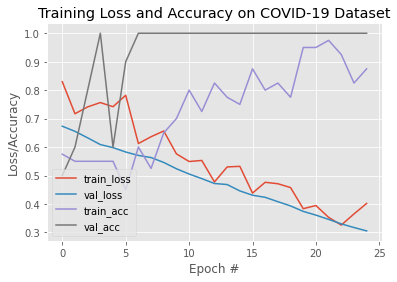

In [19]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

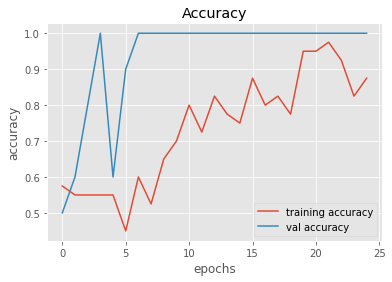

In [20]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

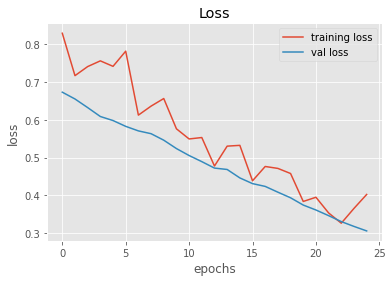

In [21]:
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [22]:
# evaluate the model
scores = model.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 97.50%


In [0]:
model.save('COVID-19', save_format="h5")